In [7]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt
from keras.applications import ResNet50
from keras.models import Model
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model


In [10]:
images_path = '/Users/rajatsharma/Desktop/My Documents/ML/Project/archive (9)/Flickr_Data/Images/'
images = glob(images_path+'*.jpg')
len(images)

8091

In [11]:
images[:5]

['/Users/rajatsharma/Desktop/My Documents/ML/Project/archive (9)/Flickr_Data/Images/2387197355_237f6f41ee.jpg',
 '/Users/rajatsharma/Desktop/My Documents/ML/Project/archive (9)/Flickr_Data/Images/2609847254_0ec40c1cce.jpg',
 '/Users/rajatsharma/Desktop/My Documents/ML/Project/archive (9)/Flickr_Data/Images/2046222127_a6f300e202.jpg',
 '/Users/rajatsharma/Desktop/My Documents/ML/Project/archive (9)/Flickr_Data/Images/2853743795_e90ebc669d.jpg',
 '/Users/rajatsharma/Desktop/My Documents/ML/Project/archive (9)/Flickr_Data/Images/2696951725_e0ae54f6da.jpg']

In [12]:
for i in range(5):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #plt.imshow(img)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [13]:

incept_model = ResNet50(include_top=True)

last = incept_model.layers[-2].output
modele = Model(inputs = incept_model.input,outputs = last)
modele.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [14]:
images_features = {}
count = 0
for i in images:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))

    img = img.reshape(1,224,224,3)
    pred = modele.predict(img).reshape(2048,)

    img_name = i.split('/')[-1]

    images_features[img_name] = pred

    count += 1

    if count>20:
        break

    if count % 50 == 0:
        print(count)


2023-11-09 11:02:46.060400: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 75ms/step


In [15]:
len(images_features)

21

In [18]:
caption_path = '/Users/rajatsharma/Desktop/My Documents/ML/Project/archive (9)/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'

In [19]:
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')

In [20]:
len(captions)

40461

In [21]:
captions_dict = {}
for i in captions:
    try:
        img_name = i.split('\t')[0][:-2]
        caption = i.split('\t')[1]
        if img_name in images_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption]

            else:
                captions_dict[img_name].append(caption)

    except:
        pass

In [22]:
len(captions_dict)

21

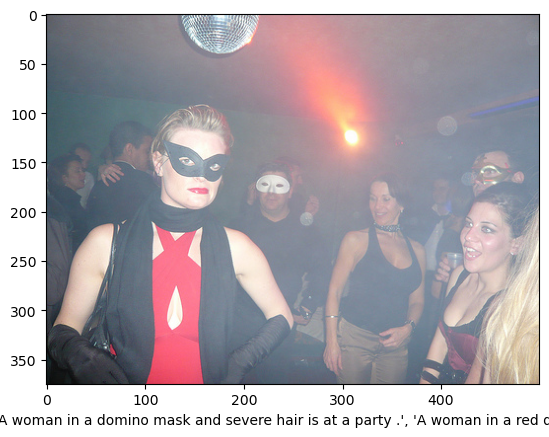

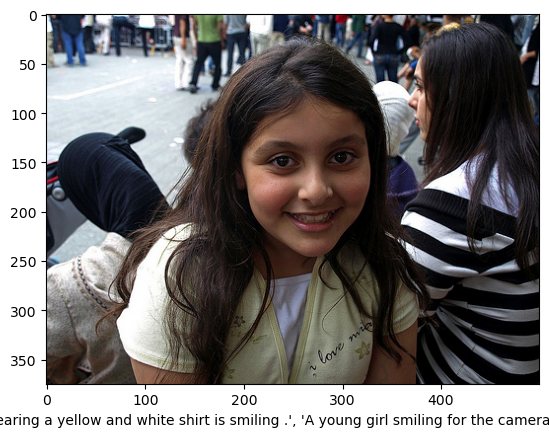

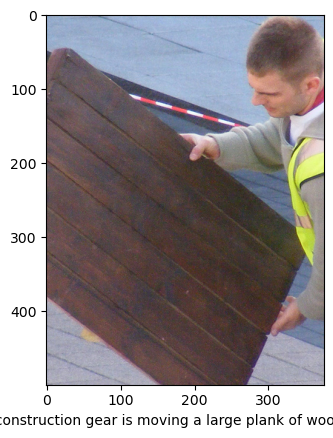

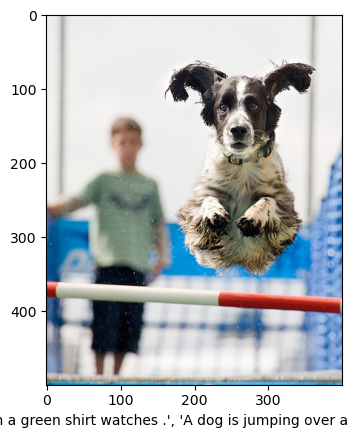

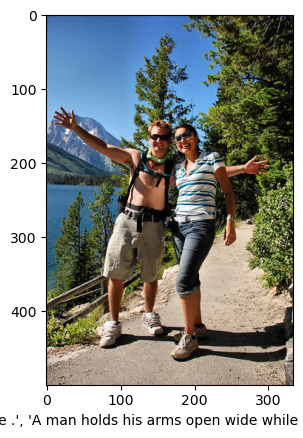

In [25]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img_name = images[i]


    img = cv2.imread(img_name)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)

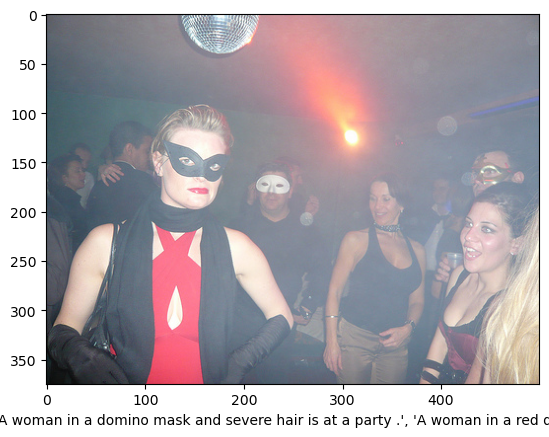

In [26]:
import matplotlib.pyplot as plt

for k in images_features.keys():
    plt.figure()

    img_name = '/Users/rajatsharma/Desktop/My Documents/ML/Project/archive (9)/Flickr_Data/Images/' + k


    img = cv2.imread(img_name)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)

    break

In [27]:
def preprocessed(txt):
    modified = txt.lower()
    modified = 'startofseq ' + modified + ' endofseq'
    return modified


In [28]:
for k,v in captions_dict.items():
    for vv in v:
        captions_dict[k][v.index(vv)] = preprocessed(vv)


In [29]:
count_words = {}
for k,vv in captions_dict.items():
    for v in vv:
        for word in v.split():
            if word not in count_words:

                count_words[word] = 0

            else:
                count_words[word] += 1

len(count_words)

343

In [30]:
THRESH = -1
count = 1
new_dict = {}
for k,v in count_words.items():
    if count_words[k] > THRESH:
        new_dict[k] = count
        count += 1

len(new_dict)

343

In [31]:
new_dict['<OUT>'] = len(new_dict)
captions_backup = captions_dict.copy()
captions_dict = captions_backup.copy()

In [32]:
for k, vv in captions_dict.items():
    for v in vv:
        encoded = []
        for word in v.split():
            if word not in new_dict:
                encoded.append(new_dict['<OUT>'])
            else:
                encoded.append(new_dict[word])


        captions_dict[k][vv.index(v)] = encoded

In [33]:
captions_dict

{'2046222127_a6f300e202.jpg': [[1, 2, 3, 4, 2, 5, 6, 7, 8, 2, 9, 10, 11, 12],
  [1, 2, 3, 4, 2, 13, 14, 6, 15, 2, 16, 17, 12],
  [1, 2, 3, 4, 18, 19, 20, 21, 2, 22, 23, 10, 11, 24, 2, 25, 26, 27, 12],
  [1, 2, 3, 28, 14, 29, 20, 30, 2, 16, 31, 27, 12],
  [1, 3, 32, 33, 34, 35, 16, 36, 27, 12]],
 '2387197355_237f6f41ee.jpg': [[1,
   2,
   37,
   10,
   38,
   39,
   40,
   41,
   2,
   42,
   43,
   27,
   12],
  [1, 2, 44, 4, 45, 46, 47, 48, 41, 49, 50, 41, 2, 51, 43, 27, 12],
  [1, 2, 52, 4, 2, 53, 54, 46, 55, 34, 20, 41, 2, 43, 27, 12],
  [1, 2, 52, 4, 2, 45, 56, 46, 47, 54, 20, 57, 2, 58, 59, 60, 12],
  [1, 2, 52, 61, 2, 45, 56, 46, 2, 47, 54, 62, 38, 59, 63, 64, 27, 12]],
 '2443229844_277cded27d.jpg': [[1,
   2,
   65,
   4,
   2,
   66,
   67,
   68,
   69,
   4,
   49,
   70,
   32,
   2,
   45,
   71,
   27,
   12],
  [1, 2, 65, 28, 2, 67, 68, 72, 2, 73, 74, 75, 76, 24, 2, 71, 27, 12],
  [1, 2, 77, 4, 2, 78, 79, 2, 80, 81, 82, 2, 45, 71, 27, 12],
  [1, 2, 83, 69, 84, 32, 2, 71, 

In [34]:
MAX_LEN = 0
for k, vv in captions_dict.items():
    for v in vv:
        if len(v) > MAX_LEN:
            MAX_LEN = len(v)
            print(v)

[1, 2, 3, 4, 2, 5, 6, 7, 8, 2, 9, 10, 11, 12]
[1, 2, 3, 4, 18, 19, 20, 21, 2, 22, 23, 10, 11, 24, 2, 25, 26, 27, 12]
[1, 2, 86, 88, 89, 90, 49, 3, 28, 91, 47, 92, 93, 94, 2, 47, 95, 24, 96, 49, 97, 27, 12]
[1, 2, 119, 86, 28, 2, 67, 121, 122, 123, 2, 43, 113, 57, 124, 125, 46, 20, 69, 4, 2, 118, 27, 12]


In [35]:
Batch_size = 5000
VOCAB_SIZE = len(new_dict)

def generator(photo, caption):
    n_samples = 0

    X = []
    y_in = []
    y_out = []

    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k])

                in_seq= [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)

    return X, y_in, y_out

In [36]:
X, y_in, y_out = generator(images_features, captions_dict)
len(X), len(y_in), len(y_out)
MAX_LEN

24

In [37]:
len(X), len(y_in), len(y_out)

(1405, 1405, 1405)

In [38]:
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')
X.shape, y_in.shape, y_out.shape

((1405, 2048), (1405, 24), (1405, 344))

In [39]:
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(new_dict)

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVector  (None, 24, 128)          0         
 )                                                               
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 24, 128)           44032     
                                                                 
 lstm (LSTM)                 (None, 24, 256)           394240    
                            

In [40]:
model.fit([X, y_in], y_out, batch_size=512, epochs=50)

Epoch 1/50
3/3 [==============================] - 5s 691ms/step - loss: 5.4354 - accuracy: 0.0868
Epoch 2/50
3/3 [==============================] - 2s 630ms/step - loss: 4.9618 - accuracy: 0.0769
Epoch 3/50
3/3 [==============================] - 2s 633ms/step - loss: 4.7281 - accuracy: 0.0847
Epoch 4/50
3/3 [==============================] - 2s 639ms/step - loss: 4.6567 - accuracy: 0.1381
Epoch 5/50
3/3 [==============================] - 2s 633ms/step - loss: 4.6365 - accuracy: 0.1381
Epoch 6/50
3/3 [==============================] - 2s 662ms/step - loss: 4.6201 - accuracy: 0.1295
Epoch 7/50
3/3 [==============================] - 2s 661ms/step - loss: 4.6028 - accuracy: 0.1217
Epoch 8/50
3/3 [==============================] - 2s 649ms/step - loss: 4.5945 - accuracy: 0.1053
Epoch 9/50
3/3 [==============================] - 2s 694ms/step - loss: 4.5531 - accuracy: 0.1381
Epoch 10/50
3/3 [==============================] - 2s 649ms/step - loss: 4.5231 - accuracy: 0.1310
Epoch 11/50
3/3 [==

In [41]:
inv_dict = {v:k for k, v in new_dict.items()}

In [42]:
model.save('model.h5')

In [43]:
model.save_weights('mine_model_weights.h5')
np.save('vocab.npy', new_dict)

def getImage(x):

    test_img_path = images[x]

    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img, (299,299))

    test_img = np.reshape(test_img, (1,299,299,3))

    return test_img

1/1 [==============================] - 0s 20ms/step


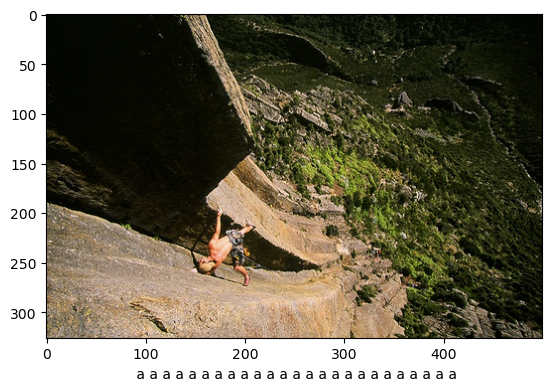

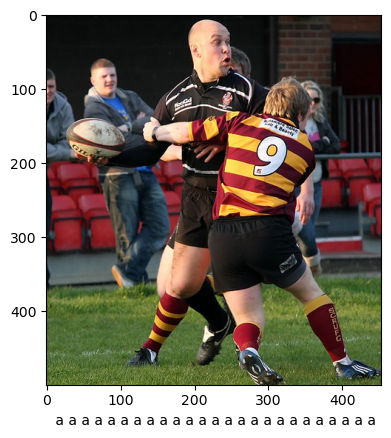

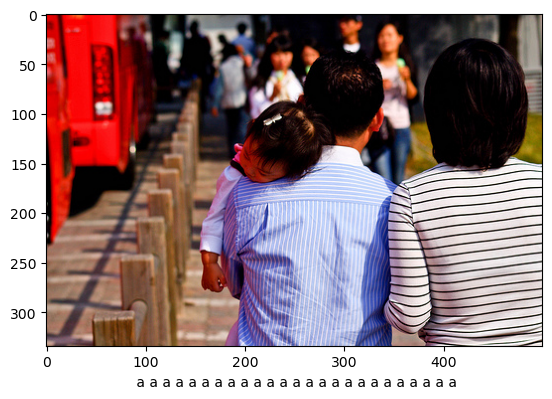

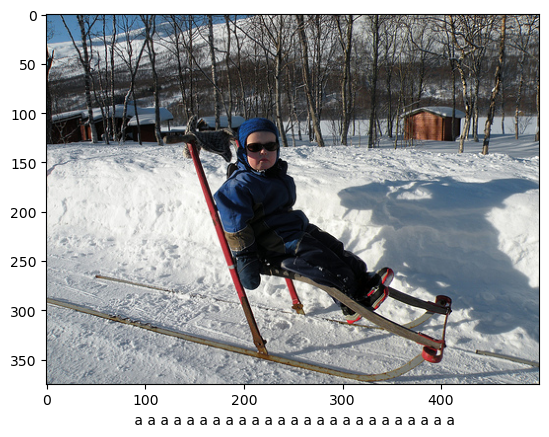

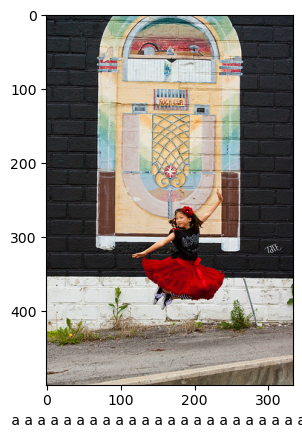

In [44]:
for i in range(5):

    no = np.random.randint(1500,7000,(1,1))[0,0]
    test_feature = modele.predict(getImage(no)).reshape(1,2048)

    test_img_path = images[no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < 25:
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(new_dict[i])

        encoded = [encoded]

        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)
        prediction = np.argmax(model.predict([test_feature, encoded]))

        sampled_word = inv_dict[prediction]

        caption = caption + ' ' + sampled_word

        if sampled_word == 'endofseq':
            break

        text_inp.append(sampled_word)

    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)
